https://www.youtube.com/watch?v=Is_sEWxeZ1E 

In [1]:
from helpers import preprocessing2d as prep
from helpers import miscellaneous as misc
import torchio as tio
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import random

from distributed import Client, LocalCluster, as_completed, fire_and_forget
from dask.distributed import progress
from dask import delayed,compute
import time

In [3]:
%timeit
from helpers import preprocessing2d as prep
from helpers import miscellaneous as misc
import torchio as tio
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import random

from distributed import Client, LocalCluster, as_completed, fire_and_forget
from dask.distributed import progress
from dask import delayed,compute
import time

def split_into_train_test(df, group_identifier, data_dir, proportion=0.8, save_files=False, file_type = "nii"):
    """
    df: file to ADNI images dataset
    group_identifier: identifier for CN, MCI or AD
    data_dir: path to all .nii files of subjects
    proportion: train/test split proportion, default: 0.8
    save_files: save as file (True/False), default: False
    """
    assert 1 > proportion > 0, f'parameter proportion has to be in range [0,1]. {proportion} was given'

    testset = pd.DataFrame(columns=['filename', 'Group', 'Subject'])
    trainset = pd.DataFrame(columns=['filename', 'Group', 'Subject'])

    filenames = misc.get_nii_filenames(data_dir)
    filenames = [i.split("../")[-1] for i in filenames]

    def get_filename_by_id(x):
        filename = [file for file in filenames if x['Image Data ID'] in file]
        if len(filename) == 1:
            return filename[0]
    #   else:
    #       print(x['Image Data ID']) # fixme missing images?

    df['filename'] = df.apply(get_filename_by_id, axis=1)

    # group by identifier
    df_grouped = df.groupby(group_identifier)

    groups = df[group_identifier].unique()
    for group in groups:
        df_group = df_grouped.get_group(group)
        subjects = df_group['Subject'].unique()
        random.seed(42)
        random.shuffle(subjects)

        n_train = int(len(subjects) * proportion)  # accordingly n_test = len(subjects) - n_train

        train_subjects = subjects[:n_train]
        test_subjects = subjects[n_train:]

        sub_trainset = df_group[df_group['Subject'].isin(train_subjects)]
        sub_testset = df_group[df_group['Subject'].isin(test_subjects)]
        
        trainset = pd.concat([trainset, sub_trainset[['filename', 'Group', 'Subject']]], ignore_index=True)
        testset = pd.concat([testset, sub_testset[['filename', 'Group', 'Subject']]], ignore_index=True)
        
    if save_files:
        trainset.to_csv('train_labels.csv', sep=',', header=True, index=False)
        testset.to_csv('test_labels.csv', sep=',', header=True, index=False)

        return None
    return trainset, testset            

def save_slices(annotations, transform, i):
    filename = annotations.filename.iloc[i]
    if isinstance(filename, str):
        name = filename.split('\\')[1]
        #name = name.replace('.nii', '.png')
        
    try:
        img = tio.ScalarImage(filename)
    except:
        print(f'Missing: {filename}')
        return
    
    nslice = img.data.size(DIMENSION)//2 #add more parameters for different slices, for example: 10%, 20%

    assert img.data.size()[3] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[3]}'
    img = img.data[:, :, :, nslice]
    if i == 0:
        print("image size before transform: ", img.shape)
    try:
        img = transform(img)
    except Exception as e:
        print(e)
        print(filename)

    if i == 0:
        print("image size after transform: ", img.shape)
    img = tio.ScalarImage(tensor=img.unsqueeze(0))
    img.save("data/processed/" + name + ".nii")

cluster = LocalCluster()
cluster.scale(4) 
client = Client(cluster)
print(cluster, client)
client

LocalCluster('tcp://127.0.0.1:54493', workers=4, nthreads=8) <Client: scheduler='tcp://127.0.0.1:54493' processes=4 cores=8>


Client Scheduler: tcp://127.0.0.1:54493 Dashboard: http://127.0.0.1:54494/status,Cluster Workers: 4 Cores: 8 Memory: 8.50 GB


In [ ]:
data_dir = "data/raw/"
df = pd.read_csv('./ADNI1_Complete_1Yr_1.5T_1_20_2022.csv')

split_into_train_test(df, 'Group', data_dir, save_files=True)

train_data = pd.read_csv('./train_labels.csv')
test_data = pd.read_csv('./test_labels.csv')

DIMENSION = 3
train_transform, val_transform = prep.get_transformer('Crop')

result= []
for i in range(len(train_data)):
    result.append(save_slices(train_data, train_transform, i))

#preprocess testset
for i in range(len(test_data)):
    result.append(save_slices(test_data, val_transform, i))

futures = client.compute(result, scheduler='processes')
progress(futures)
futures.visualize(filename='transpose.svg')

In [5]:
start = time.time()
train_data.filename = train_data.filename.str.replace('raw', 'processed', regex=True) 
test_data.filename = test_data.filename.str.replace('raw', 'processed', regex=True)   
train_data.dropna(subset=['filename'], how='all', inplace=True)
test_data.dropna(subset=['filename'], how='all', inplace=True)
train_data.to_csv('train_labels.csv', sep=',', header=True, index=False)
test_data.to_csv('test_labels.csv', sep=',', header=True, index=False)

end = time.time()
print("Completed. Elapsed time: ", end)

Completed. Elapsed time:  1656194619.4487526


In [2]:
train_data = pd.read_csv('./train_labels.csv')
test_data = pd.read_csv('./test_labels.csv')

data/raw\ADNI_941_S_1311_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080313130949784_S27408_I97327.nii
(1, 1, 224, 224)


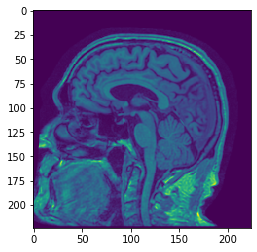

In [6]:
import matplotlib.pyplot as plt
print(train_data.filename.iloc[0])
img = tio.ScalarImage("data/processed/ADNI_094_S_0434_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070210203043456_S13570_I39122.nii")
print(img.shape)
img = img.data.squeeze()
plt.imshow(img)

In [13]:
import numpy as np
from torch.utils.data import DataLoader

from data_loader import MRIDataset
from monai.losses import FocalLoss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# import model named as Net
from ml_models import get_model

from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from dask_saturn import SaturnCluster
from dask.distributed import Client
from distributed.worker import logger

#from dask_pytorch_ddp import dispatch, results

#set different logger for different uses
def log_metric(type_, msg, logger):
    type_ = type_.replace("_", " ")
    logger.info(f"{type_} is {msg}")

def nn_train(model, device, train_dataloader, optimizer, criterion, epoch, steps_per_epoch=20):
    model.train()

    train_loss = 0
    train_total = 0
    train_correct = 0

    for batchidx, batch in enumerate(train_dataloader):
        data, target = batch["images"].to(device), batch["labels"].to(device)
        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)
        
        train_loss += loss.item()
        scores, predictions = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += int(sum(predictions == torch.argmax(target, dim=1)))
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    acc = round((train_correct / train_total) * 100, 2)
    log_metric("Epoch [{}], Loss: {}, Accuracy: {}".format(epoch, train_loss / train_total, acc), "", logger)
    log_metric('train_acc', acc, logger)
    log_metric('train_loss', train_loss, logger)
    log_metric('train_loss_ma', train_loss/train_total, logger)

    return None


def nn_test(model, device, test_dataloader, criterion, classes, return_prediction=False):
    model.eval()

    # test model
    test_loss = 0
    test_total = 0
    test_correct = 0

    y_true = []
    y_pred = []
    y_proba = None

    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch["images"].to(device), batch["labels"].to(device)
            outputs = model(inputs)
            
            test_loss += criterion(outputs, labels).item()
            scores, predictions = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += int(sum(predictions == torch.argmax(labels, dim=1)))

            outputs = outputs.cpu()
            if y_proba is None:
                y_proba = outputs
            else:
                y_proba = np.vstack((y_proba, outputs))

            for i in labels.tolist():
                y_true.append(i)
            for j in predictions.tolist():
                y_pred.append(j)

    if return_prediction:
        return y_true, y_pred, y_proba

    acc = round((test_correct / test_total) * 100, 2)
    log_metric("Test_loss: {}, Test_accuracy: {}".format(test_loss / test_total, acc), "", logger)
    log_metric('test_acc', acc, logger)
    log_metric('test_loss', test_loss, logger)
    log_metric('test_loss_ma', test_loss/test_total, logger)

    return None

model = get_model("ResNet50")

N_TRIALS: 3
LOG_MODEL: False
PRETRAINED: False
WEIGHT_DECAY: 0.15
DEVICE = "gpu"
LEARNING_RATE = 0.001
BATCH_SIZE = 2
EPOCHS = 30
TRANSFORMER = None

class_names = ['CN', 'MCI', 'AD']

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
train_transform, test_transform = prep.get_transformer("Monai_Blur")

train_dataset = MRIDataset(train_data, transform=train_transform)
test_dataset = MRIDataset(test_data, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 1)

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.15)

train_epoch_times = []
test_epoch_times = []
for epoch in range(EPOCHS):
    
    """start_epoch = time.time()
    nn_train(model, device, train_dataloader, optimizer, criterion, epoch)
    end_epoch = time.time()
    elapsed = end_epoch - start_epoch
    train_epoch_times.append(elapsed)
    log_metric('train_epoch_time', elapsed, logger)"""
    
    start_epoch = time.time()
    nn_test(model, device, test_dataloader, criterion, class_names)
    end_epoch = time.time()
    elapsed = end_epoch - start_epoch
    test_epoch_times.append(elapsed)
    log_metric('test_epoch_time', elapsed, logger)

#y_true, _, y_proba = nn_test(net, device, test_dataloader, criterion, class_names, return_prediction=True)

distributed.worker - INFO - Test loss: 2.7388037127526195, Test accuracy: 23.17 is 
distributed.worker - INFO - test acc is 23.17
distributed.worker - INFO - test loss is 1158.513970494358
distributed.worker - INFO - test loss ma is 2.7388037127526195
distributed.worker - INFO - test epoch time is 226.05618929862976


KeyboardInterrupt: 